In [1]:
import numpy as np
import tensorflow as tf
import tqdm
import networkx as nx
from sklearn.neighbors import NearestNeighbors
#from matplotlib import pyplot as plt
"""
along the lines of 
Fast Approximate Geodesics for Deep Generative Models
Nutan Chen, Francesco Ferroni, Alexej Klushyn, Alexandros Paraschos, Justin Bayer, Patrick van der Smagt
"""

class RiemannianMetric(object):
    def __init__(self, x, z, session):
        self.x = x
        self.z = z
        self.session = session

    def create_tf_graph(self):
        """
        creates the metric tensor (J^T J and J being the jacobian of the decoder), 
        which can be evaluated at any point in Z
        and
        the magnification factor
        """

        # the metric tensor
        output_dim = self.x.shape[1].value
        # derivative of each output dim wrt to input (tf.gradients would sum over the output)
        J = [tf.gradients(self.x[:, _], self.z)[0] for _ in range(output_dim)]
        J = tf.stack(J, axis=1)  # batch x output x latent
        self.J = J

        G = tf.transpose(J, [0, 2, 1]) @ J  # J^T \cdot J
        self.G = G

        # magnification factor
        MF = tf.sqrt(tf.linalg.det(G))
        self.MF = MF

    def riemannian_distance_along_line(self, z1, z2, n_steps):
        """
        calculates the riemannian distance between two near points in latent space on a straight line
        the formula is L(z1, z2) = \int_0^1 dt \sqrt(\dot \gamma^T J^T J \dot gamma)
        since gamma is a straight line \gamma(t) = t z_1 + (1-t) z_2, we get
        L(z1, z2) = \int_0^1 dt \sqrt([z_1 - z2]^T J^T J [z1-z2])
        L(z1, z2) = \int_0^1 dt \sqrt([z_1 - z2]^T G [z1-z2])
        z1: starting point
        z2: end point
        n_steps: number of discretization steps of the integral
        """

        # discretize the integral aling the line
        t = np.linspace(0, 1, n_steps)
        dt = t[1] - t[0]
        the_line = np.concatenate([_ * z1 + (1 - _) * z2 for _ in t])

        if True:
            # for weird reasons it seems to be alot faster to first eval G then do matrix mutliple outside of TF
            G_eval = self.session.run(self.G, feed_dict={self.z: the_line})

            # eval the integral at discrete point
            L_discrete = np.sqrt((z1-z2) @ G_eval @ (z1-z2).T)
            L_discrete = L_discrete.flatten()

            L = np.sum(dt * L_discrete)

        else:
            # THIS IS ALOT (10x) slower, although its all in TF
            DZ = tf.constant(z1 - z2)
            DZT = tf.constant((z1 - z2).T)
            tmp_ = tf.tensordot(self.G, DZT, axes=1)
            tmp_ = tf.einsum('j,ijk->ik', DZ[0], tmp_ )
            # tmp_ = tf.tensordot(DZ, tmp_, axes=1)

            L_discrete = tf.sqrt(tmp_)  # this is a function of z, since G(z)

            L_eval = self.session.run(L_discrete, feed_dict={self.z: the_line})
            L_eval = L_eval.flatten()
            L = np.sum(dt * L_eval)

        return L


class RiemannianTree(object):
    """docstring for RiemannianTree"""

    def __init__(self, riemann_metric):
        super(RiemannianTree, self).__init__()
        self.riemann_metric = riemann_metric  # decoder input (tf_variable)


    def create_riemannian_graph(self, z, n_steps, n_neighbors):

        n_data = len(z)
        knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
        knn.fit(z)

        G = nx.Graph()

        # Nodes
        for i in range(n_data):
            n_attr = {f'z{k}': float(z[i, k]) for k in range(z.shape[1])}
            G.add_node(i, **n_attr)

        # edges
        for i in tqdm.trange(n_data):
            distances, indices = knn.kneighbors(z[i:i+1])
            # first dim is for samples (z), but we only have one
            distances = distances[0]
            indices = indices[0]

            for ix, dist in zip(indices, distances):
                # calculate the riemannian distance of z[i] and its nn

                # save some computation if we alrdy calculated the other direction
                if (i, ix) in G.edges_iter() or (ix, i) in G.edges_iter() or i == ix:
                    continue

                L_riemann = self.riemann_metric.riemannian_distance_along_line(z[i:i+1], z[ix:ix+1], n_steps=n_steps)
                L_euclidean = dist

                # note nn-distances are NOT symmetric
                edge_attr = {'weight': float(1/L_riemann),
                             'weight_euclidean': float(1/L_euclidean),
                             'distance_riemann': float(L_riemann),
                             'distance_euclidean': float(L_euclidean)}
                G.add_edge(i, ix, **edge_attr)
        return G




/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/ten

In [113]:
G = nx.Graph()

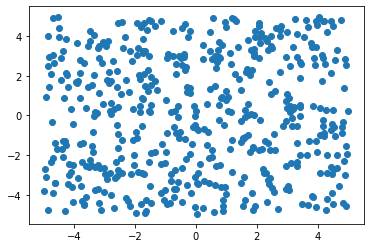

In [409]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
latent_dim = 10
output_dim = 300
m = Sequential()
m.add(Dense(200, activation='relu', input_shape=(latent_dim, )))
m.add(Dense(200, activation='relu', ))
m.add(Dense(output_dim, activation='sigmoid'))
m.compile(optimizer='Adam', loss='binary_crossentropy')

# plot the model real quick
inp = np.random.uniform(-5,5, size=(500, latent_dim))
outp = m.predict(inp)

plt.figure()
plt.scatter(inp[:,0], inp[:,1])



In [407]:
from sklearn.datasets import load_digits
>>> from sklearn.manifold import SpectralEmbedding
>>> X, _ = load_digits(return_X_y=True)

In [34]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 2  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

############
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [35]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [36]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)


(60000, 784)


In [37]:
x_train.sample(1000, replace=False)

AttributeError: 'numpy.ndarray' object has no attribute 'sample'

In [38]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [40]:
autoencoder.fit(x_train[0:2000], x_train[0:2000],
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test[0:2000], x_test[0:2000]))

Train on 2000 samples, validate on 2000 samples
Epoch 1/200
2000/2000 [==============================] - 0s 19us/step - loss: 0.2791 - val_loss: 0.2793
Epoch 2/200
2000/2000 [==============================] - 0s 18us/step - loss: 0.2781 - val_loss: 0.2781
Epoch 3/200
2000/2000 [==============================] - 0s 16us/step - loss: 0.2772 - val_loss: 0.2772
Epoch 4/200
2000/2000 [==============================] - 0s 18us/step - loss: 0.2765 - val_loss: 0.2763
Epoch 5/200
2000/2000 [==============================] - 0s 17us/step - loss: 0.2759 - val_loss: 0.2756
Epoch 6/200
2000/2000 [==============================] - 0s 18us/step - loss: 0.2753 - val_loss: 0.2751
Epoch 7/200
2000/2000 [==============================] - 0s 17us/step - loss: 0.2748 - val_loss: 0.2746
Epoch 8/200
2000/2000 [==============================] - 0s 17us/step - loss: 0.2743 - val_loss: 0.2740
Epoch 9/200
2000/2000 [==============================] - 0s 18us/step - loss: 0.2739 - val_loss: 0.2736
Epoch 10/200
200

In [55]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test[0:2000])
decoded_imgs = decoder.predict(encoded_imgs)

In [7]:
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [12]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
inp_comps = pca.fit_transform(encoded_imgs)

#plt.scatter(inp_comps[:,0], inp_comps[:,1])


In [42]:

session = tf.Session()
session.run(tf.global_variables_initializer())

rmetric = RiemannianMetric(x=autoencoder.output, z=encoded, session=session)


In [43]:
rmetric

In [44]:
rmetric.create_tf_graph()

In [47]:
%%time

mf = session.run(rmetric.MF, {rmetric.z: encoded_imgs[0:10]})


CPU times: user 41.3 ms, sys: 0 ns, total: 41.3 ms
Wall time: 40.3 ms


In [48]:
%%time

mf = session.run(rmetric.MF, {rmetric.z: encoded_imgs[0:20]})


CPU times: user 39.8 ms, sys: 3.57 ms, total: 43.4 ms
Wall time: 41.6 ms


In [49]:
%%time

mf = session.run(rmetric.MF, {rmetric.z: encoded_imgs[0:50]})


CPU times: user 35.7 ms, sys: 193 µs, total: 35.9 ms
Wall time: 35.6 ms


In [50]:

mf = session.run(rmetric.MF, {rmetric.z: encoded_imgs[0:2000]})


In [52]:
mf.shape

(2000,)

In [23]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
inp_comps = pca.fit_transform(encoded_imgs)

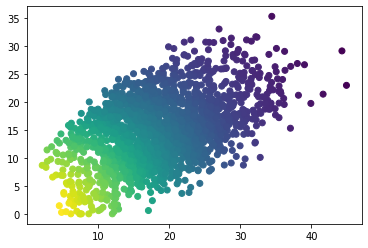

In [56]:
from matplotlib import pyplot as plt 

plt.figure()
plt.scatter(encoded_imgs[:,0], encoded_imgs[:,1], c=mf)

In [59]:

>>> from sklearn.manifold import SpectralEmbedding

>>> embedding = SpectralEmbedding(n_components=2, n_neighbors=5, gamma=1)
>>> X_transformed = embedding.fit_transform(encoded_imgs)
>>> X_transformed.shape

/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(2000, 2)

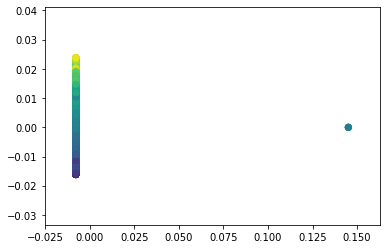

In [60]:
plt.figure()
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=mf)

In [347]:

rTree = RiemannianTree(rmetric)
G = rTree.create_riemannian_graph(inp, n_steps=1000, n_neighbors=10)




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:02<17:32,  2.11s/it]

  0%|          | 2/500 [00:02<13:03,  1.57s/it]

  1%|          | 3/500 [00:02<09:56,  1.20s/it]

  1%|          | 4/500 [00:03<07:44,  1.07it/s]

  1%|          | 5/500 [00:03<06:12,  1.33it/s]

  1%|          | 6/500 [00:03<05:05,  1.61it/s]

  1%|▏         | 7/500 [00:04<04:21,  1.88it/s]

  2%|▏         | 8/500 [00:04<03:50,  2.13it/s]

  2%|▏         | 9/500 [00:04<03:28,  2.36it/s]

  2%|▏         | 10/500 [00:04<03:07,  2.62it/s]

  2%|▏         | 11/500 [00:05<02:52,  2.84it/s]

  2%|▏         | 12/500 [00:05<02:48,  2.90it/s]

  3%|▎         | 13/500 [00:05<02:44,  2.96it/s]

  3%|▎         | 14/500 [00:06<02:40,  3.02it/s]

  3%|▎         | 15/500 [00:06<02:39,  3.05it/s]

  3%|▎         | 16/500 [00:06<02:39,  3.04it/s]

  3%|▎         | 17/500 [00:07<02:37,  3.06it/s]

  4%|▎         | 18/500 [00:07<02:31,  3.18it/s]

  4%|▍         | 19/500 [00:07<02:28,  3.24it/s]

  4%|▍         |

In [351]:
from networkx.algorithms.shortest_paths.generic import shortest_path
paths = shortest_path(G)


In [352]:
shortest_paths = []
for i in range(0,100):
   
    shortest_path_lengths = np.array([len(x) for x in paths[i].values()])

    shortest_paths.append(shortest_path_lengths)

In [353]:
shortest_paths = np.array(shortest_paths)
shortest_paths.shape

(100, 500)

In [354]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
shortest_paths_comps = pca.fit_transform(shortest_paths)

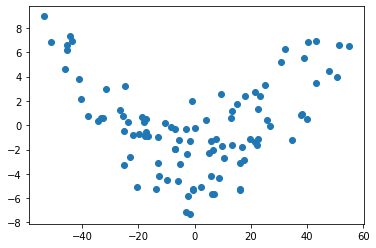

In [355]:
plt.figure()
plt.scatter(shortest_paths_comps[:,0], shortest_paths_comps[:,1])


In [215]:
shortest_path_mat = np.zeros(z.shape[0])

for i in range(z.shape[0]):
    shortest_path_mat[i] = np.array([len(x) for x in paths[i].values()])

ValueError: setting an array element with a sequence.

In [100]:

mf = session.run(rmetric.MF, {rmetric.z: inp})

In [101]:
mf

array([1.31575476e-07, 2.69903655e-08, 1.28794468e-08, 5.60382531e-08,
       1.23839106e-09, 4.20472901e-09, 8.66296368e-09, 4.21753210e-09,
       7.03650782e-09, 1.83722637e-08, 2.04614867e-08, 3.45475506e-08,
       6.23850838e-09, 1.68534218e-08, 4.88163380e-07, 5.83552850e-09,
       9.63724005e-07, 7.99897180e-08, 1.17756031e-07, 6.13042461e-09,
       1.22478895e-07, 2.19890985e-08, 3.87781576e-08, 2.73651430e-08,
       1.76636394e-09, 5.57168933e-09, 6.13628899e-08, 5.41490186e-09,
       6.26487520e-08, 6.24975138e-09, 3.88809340e-09, 3.36111370e-08,
       2.04031068e-08, 3.99565447e-09, 3.00882839e-08, 4.74397304e-08,
       2.94410576e-08, 2.41349660e-08, 2.88170810e-07, 6.97754601e-08,
       5.16693817e-08, 1.29185160e-08, 6.65513555e-09, 3.86525478e-08,
       6.23553760e-08, 5.60524427e-09, 1.23597061e-08, 1.56336419e-08,
       7.67340858e-09, 1.12289404e-08, 1.16792634e-07, 4.94593621e-07,
       5.71303218e-08, 3.29424346e-08, 1.03798641e-08, 9.81230475e-09,
      

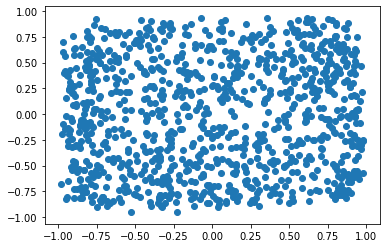

In [103]:

z1 = np.array([[1, 10]])
z2 = np.array([[10, 2]])

# for steps in [100,1_000,10_000,100_000]:
#     q = r.riemannian_distance_along_line(z1, z2, n_steps=steps)
#     print(q)


import sklearn.datasets
z, _  = sklearn.datasets.make_swiss_roll(n_samples=1000, noise=0.5, random_state=None)
z = z[:,[0,2]]

z = np.random.uniform(-50,50, size=(1000, latent_dim))


# plt.scatter(z[:,0], z[:,1])
outp = m.predict(z)
plt.figure()
plt.scatter(outp[:,0], outp[:,1])

rTree = RiemannianTree(rmetric)

In [104]:
z, _  = sklearn.datasets.make_swiss_roll(n_samples=1000, noise=0.5, random_state=None)

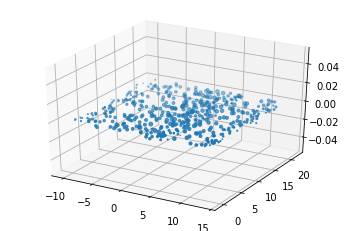

In [105]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.scatter(z[:,0], z[:,1],  z[:,2])

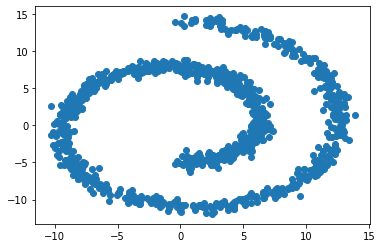

In [106]:
z = z[:,[0,2]]
plt.scatter(z[:,0], z[:,1])

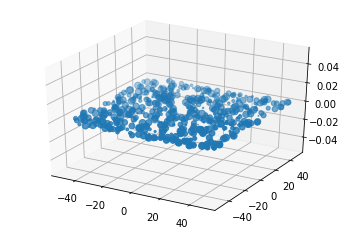

In [107]:
z = np.random.uniform(-50,50, size=(1000, latent_dim))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.scatter(z[:,0], z[:,1],  z[:,2])

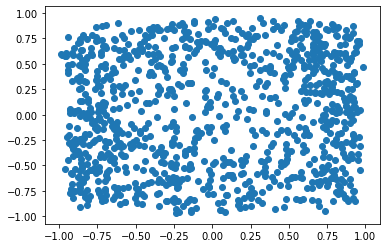

In [108]:
# plt.scatter(z[:,0], z[:,1])
outp = m.predict(z)
plt.figure()
plt.scatter(outp[:,0], outp[:,1])

In [213]:
G = rTree.create_riemannian_graph(z, n_steps=1000, n_neighbors=10)


100%|██████████| 1000/1000 [00:57<00:00, 17.27it/s]


In [110]:
z

array([[-34.64858723,  11.75189454,   6.07691732,  31.188592  ,
        -47.7549949 ],
       [-14.57299985,  -7.40501759,  23.99410969,   4.39951741,
         24.23268598],
       [ 34.9023621 ,  26.88158077, -31.80988638, -47.37831227,
         47.90470704],
       ...,
       [-16.37945505,  18.10090028,  30.35809459, -26.93536157,
         27.65482655],
       [ 26.39875667,  39.8672427 , -42.52353029,  49.23025823,
         -1.72779736],
       [ 46.12645375,  -5.02245828,  33.35864689,  40.02360234,
          6.53897491]])

100%|██████████| 1000/1000 [00:57<00:00, 17.51it/s]


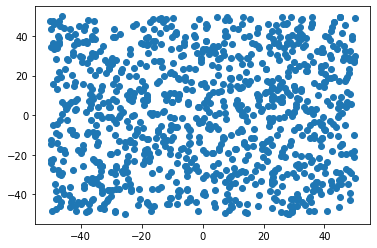

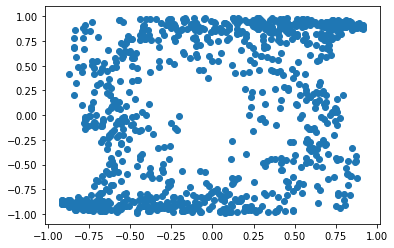

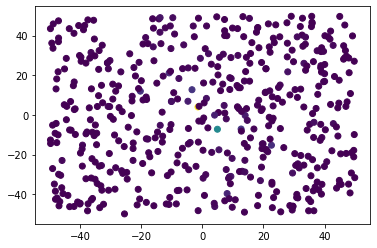

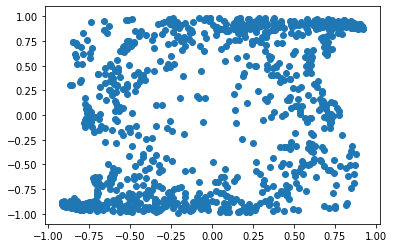

In [168]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
latent_dim = 3
output_dim = 2
m = Sequential()
m.add(Dense(200, activation='tanh', input_shape=(latent_dim, )))
m.add(Dense(200, activation='tanh', ))
m.add(Dense(output_dim, activation='tanh'))


# plot the model real quick
inp = np.random.uniform(-50,50, size=(1000, latent_dim))
outp = m.predict(inp)

plt.figure()
plt.scatter(inp[:,0], inp[:,1])
plt.figure()
plt.scatter(outp[:,0], outp[:,1])


session = tf.Session()
session.run(tf.global_variables_initializer())

rmetric = RiemannianMetric(x=m.output, z=m.input, session=session)
rmetric.create_tf_graph()

mf = session.run(rmetric.MF, {rmetric.z: inp})
plt.figure()
plt.scatter(inp[:,0], inp[:,1], c=mf)

z1 = np.array([[1, 10]])
z2 = np.array([[10, 2]])

# for steps in [100,1_000,10_000,100_000]:
#     q = r.riemannian_distance_along_line(z1, z2, n_steps=steps)
#     print(q)


import sklearn.datasets
z, _  = sklearn.datasets.make_swiss_roll(n_samples=1000, noise=0.5, random_state=None)
z = z[:,[0,2]]

z = np.random.uniform(-50,50, size=(1000, latent_dim))

# plt.scatter(z[:,0], z[:,1])
outp = m.predict(z)
plt.figure()
plt.scatter(outp[:,0], outp[:,1])

rTree = RiemannianTree(rmetric)

G = rTree.create_riemannian_graph(z, n_steps=1000, n_neighbors=10)

# can use G to do shortest path finding now

In [173]:
from networkx.algorithms.shortest_paths.generic import shortest_path
paths = shortest_path(G)

In [181]:
path_values = paths.values()

In [196]:
from networkx.algorithms.shortest_paths.generic import shortest_path
paths = shortest_path(G)
shortest_path_mat = np.zeros(z.shape[0])

for i in range(z.shape[0]):
    shortest_path_mat[i] = np.array([len(x) for x in paths[i].values()])

ValueError: setting an array element with a sequence.

In [205]:
np.array([len(x) for x in paths[6].values()])

array([ 1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 13, 13])

In [212]:
paths[193].shape

AttributeError: 'dict' object has no attribute 'shape'

In [201]:
np.array([len(x) for x in paths[1].values()]

SyntaxError: unexpected EOF while parsing (<ipython-input-201-285f89d0927d>, line 1)

In [187]:
shortest_path_mat = np.zeros(z.shape)

for i in range(z.shape[0]):
    shortest_path_mat[i, :] = np.array([len(x) for x in p[i].values()])

AttributeError: 'int' object has no attribute 'values'

In [186]:
p[i]

(1000, 3)

AttributeError: module 'matplotlib.cbook' has no attribute 'is_string_like'

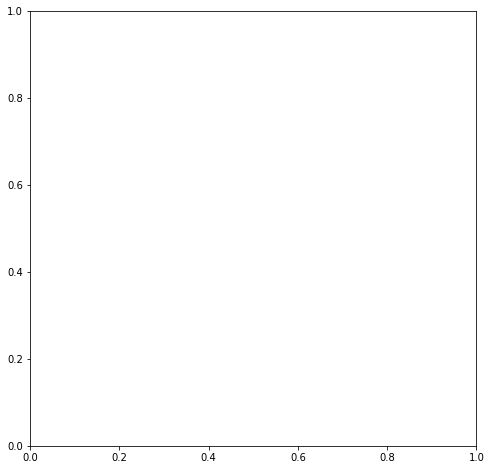

In [170]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.random_geometric_graph(200, 0.125)
# position is stored as node attribute data for random_geometric_graph
pos = nx.get_node_attributes(G, 'pos')

# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
for n in pos:
    x, y = pos[n]
    d = (x - 0.5)**2 + (y - 0.5)**2
    if d < dmin:
        ncenter = n
        dmin = d

# color by path length from node near center
p = dict(nx.single_source_shortest_path_length(G, ncenter))

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G, pos, nodelist=[ncenter], alpha=0.4)
nx.draw_networkx_nodes(G, pos, nodelist=list(p.keys()),
                       node_size=80,
                       node_color=list(p.values()),
                       cmap=plt.cm.Reds_r)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis('off')
plt.show()

In [138]:

import networkx as nx
from functools import wraps, partial
import numpy as np
from matplotlib.collections import LineCollection, PathCollection
from matplotlib.markers import MarkerStyle
from matplotlib.artist import Artist
from matplotlib.text import Text

#from ._layout import _apply_layout

import networkx as nx


KNOWN_LAYOUTS = {
    "spring": nx.spring_layout,
    "circular": nx.circular_layout,
    "random": nx.random_layout,
  #  "kamada_kawai": nx.kamada_kawai_layout,
    "shell": nx.shell_layout,
    "spectral": nx.spectral_layout,
    }


def _apply_layout(layout, graph):
    if callable(layout):
        return layout(graph)
    elif isinstance(layout, str):
        return KNOWN_LAYOUTS[layout](graph)
    else:
        raise ValueError("Dunno what do do with this")
        
#################################################        

_VALID_NODE_STYLE = ['size', 'color', 'shape', 'width',
                     'edgecolor']

_VALID_EDGE_STYLE = ['color', 'width', 'style']

_VALID_NODE_LABEL_STYLE = ['bbox',
                           'font_size',
                           'font_color',
                           'font_family',
                           'font_weight',
                           'horizontalalignment',
                           'verticalalignment']

_VALID_EDGE_LABEL_STYLE = ['bbox',
                           'label_pos',
                           'rotate',
                           'font_size',
                           'font_color',
                           'font_family',
                           'font_weight',
                           'horizontalalignment',
                           'verticalalignment']

_ALL_STYLE_KEYS = _VALID_NODE_STYLE + _VALID_NODE_LABEL_STYLE + \
                  _VALID_EDGE_STYLE + _VALID_EDGE_LABEL_STYLE


def default_node_style():
    return {'color': 'C0',
            'size': 50,
            'shape': 'o',
            'width': 1,
            'edgecolor': 'white'}


def default_edge_style():
    return {'color': '#292929',
            'width': 1,
            'style': '-'}


# box of white with white border
_BBOX_DEFAULT = dict(boxstyle='round',
                     ec=(1.0, 1.0, 1.0),
                     fc=(1.0, 1.0, 1.0),
                     )


def default_node_label_style():
    return {'bbox': _BBOX_DEFAULT,
            'font_size': 4,
            'font_color': '#292929',
            'font_family': None,
            'font_weight': 1,
            'horizontalalignment': 'center',
            'verticalalignment': 'center'}


def default_edge_label_style():
    return {'bbox': _BBOX_DEFAULT,
            'label_pos': 0.5,
            'rotate': 0,
            'font_size': 4,
            'font_color': '#292929',
            'font_family': None,
            'font_weight': 1,
            'horizontalalignment': 'center',
            'verticalalignment': 'center'}


def default_style():
    return {'node_style': default_node_style,
            'edge_style': default_edge_style}


def style_merger(*funcs):
    def inner(node_attributes):
        out = {}
        for f in funcs:
            out.update(f(node_attributes))
        return out

    return inner


def use_attributes(keys=None):
    '''Utility style function that searches the given
    attribute dictionary for valid style attributes and bundles
    them into a style dictionary.
    Parameters
    ----------
    keys : str or iterable, optional
        Style keys to search for.
    Returns
    -------
    inner : function
        A style function.
    '''

    def inner(attributes):
        if keys is None:
            return {k: attributes[k] for k in _ALL_STYLE_KEYS
                    if k in attributes}
        if isinstance(keys, str):
            return {keys: attributes[keys]} if keys in attributes else {}
        else:
            return {key: attributes[key] for key in keys
                    if key in attributes}
    return inner


def apply_style(style, item_iterable, default):
    styles = {}
    if callable(style):
        for item, item_attr in item_iterable:
            base = default()
            base.update(style(item_attr))
            styles[item] = base
    elif isinstance(style, dict):
        base = default()
        base.update(style)
        for item, item_attr in item_iterable:
            styles[item] = base
    else:
        raise TypeError("style must be dict or callable,"
                        " got {0}".format(type(style)))
    return styles


def generate_node_styles(network, node_style):
    # dict of node id -> node_style_dict
    return apply_style(node_style,
                       network.nodes.items(),
                       default_node_style)


def generate_edge_styles(network, edge_style):
    # dict of edge tuple -> edge_style_dict
    return apply_style(edge_style,
                       network.edges_iter(),
                       default_edge_style)


def generate_node_label_styles(network, label_style):
    # returns dict of node id -> node_style_dict
    return apply_style(label_style,
                       network.nodes.items(),
                       default_node_label_style)


def generate_edge_label_styles(network, label_style):
    # returns dict of edge tuple -> edge_style_dict
    return apply_style(label_style,
                       network.edges_iter(),
                       default_edge_label_style)
####################################################
def _ensure_ax(func):
    """Ensure that the wrapped function get an Axes
    If one is not passed in explicitly, ask pyplot for the current Axes
    """
    @wraps(func)
    def inner(*args, **kwargs):
        if 'ax' not in kwargs:
            import matplotlib.pyplot as plt
            kwargs['ax'] = plt.gca()
        return func(*args, **kwargs)

    return inner


def _generate_node_artist(pos, styles, *, ax):
    N = len(pos)
    proto_node = next(iter(pos))
    node_indx = [None] * N
    x = np.zeros(N) * np.nan
    y = np.zeros(N) * np.nan
    properties = {k: [None] * N for k in styles[proto_node]
                  if k in _VALID_NODE_STYLE}

    for j, node in enumerate(pos):
        x[j], y[j] = pos[node]
        for key, values in properties.items():
            values[j] = styles[node][key]
        node_indx[j] = node

    key_map = {'size': 'sizes', 'color': 'facecolors', 'shape': 'marker',
               'width': 'linewidths', 'edgecolor': 'edgecolors'}
    renamed_properties = {key_map[k]: v
                          for k, v in properties.items()}

    markers = renamed_properties.pop('marker', None)

    if markers is None:
        paths = (MarkerStyle('o'), )
    else:
        paths = [MarkerStyle(m) for m in markers]
    paths = [p.get_path().transformed(p.get_transform()) for p in paths]

    offsets = np.column_stack([x, y])
    node_art = PathCollection(paths,
                              offsets=offsets,
                              transOffset=ax.transData,
                              **renamed_properties)

    return node_art, node_indx


def _generate_straight_edges(edges, pos, styles, *, ax):
    N = len(edges)
    if not N:
        return None, None
    proto_edge = next(iter(edges))
    edge_pos = [None] * N
    edge_indx = [None] * N
    properties = {k: [None] * N for k in styles[proto_edge]
                  if k in _VALID_EDGE_STYLE}

    for j, (u, v) in enumerate(edges):
        edge_pos[j] = (pos[u], pos[v])
        for key, values in properties.items():
            values[j] = styles[(u, v)][key]
        edge_indx[j] = (u, v)
    key_map = {'color': 'colors',
               'width': 'linewidths',
               'style': 'linestyle',}

    renamed_properties = {key_map[k]: v
                          for k, v in properties.items()}
    line_art = LineCollection(edge_pos,
                              transOffset=ax.transData,
                              zorder=1,
                              **renamed_properties)
    line_art.set_transform(ax.transData)
    return line_art, edge_indx


def _generate_node_labels(pos, styles, *, ax):
    key_map = {'font_size': 'size',
               'font_color': 'color',
               'font_family': 'family',
               'font_weight': 'weight',
               'alpha': 'alpha',
               'bbox': 'bbox',
               'horizontalalignment': 'horizontalalignment',
               'verticalalignment': 'verticalalignment'}

    node_labels_dict = {}
    for node, nstyle in styles.items():
        properties = {key_map[k]: v for k, v in nstyle.items()
                      if k in key_map}

        x, y = pos[node]

        if 'label' in nstyle:
            label = nstyle['label']
        else:
            label = str(node)    # this makes "1" and 1 the same

        node_labels_dict[node] = Text(x, y,
                                      label,
                                      transform=ax.transData,
                                      clip_on=True,
                                      **properties)
    return node_labels_dict


def _generate_edge_labels(pos, styles, *, ax):
    key_map = {'font_size': 'size',
               'font_color': 'color',
               'font_family': 'family',
               'font_weight': 'weight',
               'alpha': 'alpha',
               'bbox': 'bbox',
               'horizontalalignment': 'horizontalalignment',
               'verticalalignment': 'verticalalignment'}

    edge_labels_dict = {}
    for edge, estyle in styles.items():
        properties = {key_map[k]: v for k, v in estyle.items()
                      if k in key_map}

        if 'label' in estyle:
            label = estyle['label']
        else:
            label = str(edge)    # this makes "1" and 1 the same

        if 'label_pos' in estyle:
            label_pos = estyle['label_pos']
        else:
            label_pos = 0.5

        (x1, y1) = pos[edge[0]]
        (x2, y2) = pos[edge[1]]
        (x, y) = (x1 * label_pos + x2 * (1.0 - label_pos),
                  y1 * label_pos + y2 * (1.0 - label_pos))

        if 'rotate' in estyle and estyle['rotate'] is True:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < - 90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(np.array((angle,)),
                                                        xy.reshape((1, 2)))[0]
        else:
            trans_angle = 0.0

        edge_labels_dict[edge] = Text(x, y,
                                      label,
                                      rotation=trans_angle,
                                      transform=ax.transData,
                                      clip_on=True,
                                      zorder=1,
                                      **properties)
    return edge_labels_dict


def _forwarder(forwards, cls=None):
    if cls is None:
        return partial(_forwarder, forwards)

    def make_forward(name):
        def method(self, *args, **kwargs):
            ret = getattr(cls.mro()[1], name)(self, *args, **kwargs)
            for c in self.get_children():
                getattr(c, name)(*args, **kwargs)
            return ret

        return method

    for f in forwards:
        method = make_forward(f)
        method.__name__ = f
        method.__doc__ = 'broadcasts {} to children'.format(f)
        setattr(cls, f, method)

    return cls


def _stale_wrapper(func):
    @wraps(func)
    def inner(self, *args, **kwargs):
        try:
            func(self, *args, **kwargs)
        finally:
            self.stale = False
    return inner


@_forwarder(('set_clip_path', 'set_clip_box', 'set_transform',
             'set_snap', 'set_sketch_params', 'set_figure',
             'set_animated', 'set_picker'))
class NXArtist(Artist):
    def __init__(self, graph, layout, node_style, edge_style,
                 node_label_style=None,
                 edge_label_style=None,
                 ):
        super().__init__()
        self.graph = graph
        self.layout = layout
        self.node_style = node_style
        self.edge_style = edge_style
        self.node_label_style = node_label_style
        self.edge_label_style = edge_label_style

        # update the layout once so we can use
        # get_datalim before we draw
        self._pos = _apply_layout(self.layout, graph)
        self._node_artist = None
        self._node_indx = None
        self._edge_artist = None
        self._edge_indx = None
        self._node_label_dict = None
        self._edge_label_dict = None

    def _clear_state(self):
        self._node_artist = None
        self._node_indx = None
        self._edge_artist = None
        self._edge_indx = None
        self._node_label_dict = None
        self._edge_label_dict = None

    def get_children(self):
        artists = [self._edge_artist, self._node_artist]
        if self._node_label_dict is not None:
            artists.extend(self._node_label_dict.values())
        if self._edge_label_dict is not None:
            artists.extend(self._edge_label_dict.values())
        return tuple(a for a in artists if a is not None)

    def get_datalim(self):
        pos = np.vstack(list(self._pos.values()))

        mins = pos.min(axis=0)
        maxs = pos.max(axis=0)

        return (mins, maxs)

    def _reprocess(self, *, reset_pos=True):
        # nuke old state and mark as stale
        self._clear_state()
        self.stale = True

        # get local refs to everything (just for less typing)
        graph = self.graph
        edge_style = self.edge_style
        node_style = self.node_style
        edge_label_style = self.edge_label_style
        node_label_style = self.node_label_style

        # update the layout
        if reset_pos:
            self._pos = _apply_layout(self.layout, graph)
        pos = self._pos

        # handle the edges
        edge_style_dict = generate_edge_styles(graph, edge_style)
        self._edge_artist, self._edge_indx = (
            _generate_straight_edges(graph.edges_iter(), pos,
                                     edge_style_dict, ax=self.axes))

        # handle the nodes
        node_style_dict = generate_node_styles(graph, node_style)
        self._node_artist, self._node_indx = (
            _generate_node_artist(pos, node_style_dict, ax=self.axes))

        # TODO handle the text

        # handle the node labels
        if node_label_style is not None:
            nlabel_style_dict = generate_node_label_styles(graph,
                                                           node_label_style)
            self._node_label_dict = (
                _generate_node_labels(pos, nlabel_style_dict, ax=self.axes))

        # handle the edge labels
        if edge_label_style is not None:
            elabel_style_dict = generate_edge_label_styles(graph,
                                                           edge_label_style)
            self._edge_label_dict = (
                _generate_edge_labels(pos, elabel_style_dict, ax=self.axes))

        # TODO sort out all of the things that need to be forwarded
        for child in self.get_children():
            # set the figure / axes on child, this is needed
            # by some internals
            child.set_figure(self.figure)
            child.axes = self.axes
            # forward the clippath/box to the children need this logic
            # because mpl exposes some fast-path logic
            clip_path = self.get_clip_path()
            if clip_path is None:
                clip_box = self.get_clip_box()
                child.set_clip_box(clip_box)
            else:
                child.set_clip_path(clip_path)

    @_stale_wrapper
    def draw(self, renderer, *args, **kwargs):
        if not self.get_visible():
            return

        if not self.get_children():
            self._reprocess()

        elif self.stale:
            self._reprocess(reset_pos=False)

        for art in self.get_children():
            art.draw(renderer, *args, **kwargs)

    def contains(self, mouseevent):
        props = {}
        edge_hit, edge_props = self._edge_artist.contains(mouseevent)
        node_hit, node_props = self._node_artist.contains(mouseevent)
        props['nodes'] = [self._node_indx[j]
                          for j in node_props.get('ind', [])]
        props['edges'] = [self._edge_indx[j]
                          for j in edge_props.get('ind', [])]

        return edge_hit | node_hit, props

    def pick(self, mouseevent):
        # Pick self
        if self.pickable():
            picker = self.get_picker()
            if callable(picker):
                inside, prop = picker(self, mouseevent)
            else:
                inside, prop = self.contains(mouseevent)
            if inside:
                self.figure.canvas.pick_event(mouseevent, self, **prop)


@_ensure_ax
def plot_network(graph, layout="spring",
                 node_style=None,
                 edge_style=None,
                 node_label_style=None,
                 edge_label_style=None,
                 *, ax):
    """
    Plot network
    Parameters
    ----------
    graph : networkx graph object
    layout : string or callable, optional, default: "spring"
        Specifies the type of layout to use for plotting.
        It must be one of "spring", "circular", "random", "kamada_kawai",
        "shell", "spectral", or a callable.
        If a callable is given, it is used to compute the 2D coordinates from
        the graph object, and should return a FIXME.
        
    """
    if node_style is None:
        node_style = {}

    if edge_style is None:
        edge_style = {}

    art = NXArtist(graph, layout, node_style, edge_style,
                   node_label_style, edge_label_style)
    ax.add_artist(art)
    art._reprocess()
    ax.update_datalim(art.get_datalim())
    ax.autoscale_view()
    ax.set_axis_off()

    return art


In [167]:
import networkx as nx

G=nx.Graph()

# adding just one node:
G.add_node("a")
# a list of nodes:
G.add_nodes_from(["b","c"])

print("Nodes of graph: ")
print(G.nodes())
print("Edges of graph: ")
print(G.edges())

Nodes of graph: 
['a', 'b', 'c']
Edges of graph: 
[]


In [165]:
import pygraphviz

ModuleNotFoundError: No module named 'pygraphviz'

In [166]:
>>> G = nx.petersen_graph()
>>> pos = nx.nx_agraph.graphviz_layout(G)
>>> pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

ImportError: ('requires pygraphviz ', 'http://networkx.lanl.gov/pygraphviz ', '(not available for Python3)')

In [151]:
# process.py - http://www.graphviz.org/content/process

from graphviz import Graph

g = Graph(G)

g.edge('run', 'intr')
g.edge('intr', 'runbl')
g.edge('runbl', 'run')
g.edge('run', 'kernel')
g.edge('kernel', 'zombie')
g.edge('kernel', 'sleep')
g.edge('kernel', 'runmem')
g.edge('sleep', 'swap')
g.edge('swap', 'runswap')
g.edge('runswap', 'new')
g.edge('runswap', 'runmem')
g.edge('new', 'runmem')
g.edge('sleep', 'runmem')

g.view()

ExecutableNotFound: failed to execute ['dot', '-Tpdf', '-O', 'cluster.gv'], make sure the Graphviz executables are on your systems' PATH

In [38]:
#3  Dimensional - corresponds to latent dim
rTree.riemann_metric.z.shape

#2 Dimensional - Corresponds to output dim 
rTree.riemann_metric.x.shape

TensorShape([Dimension(None), Dimension(2)])

In [ ]:
outp.shape

In [7]:

# plot the model real quick
inp = np.random.uniform(-50,50, size=(1000, latent_dim))
outp = m.predict(inp)

plt.figure()
plt.scatter(inp[:,0], inp[:,1])
plt.figure()
plt.scatter(outp[:,0], outp[:,1])


session = tf.Session()
session.run(tf.global_variables_initializer())

rmetric = RiemannianMetric(x=m.output, z=m.input, session=session)
rmetric.create_tf_graph()

mf = session.run(rmetric.MF, {rmetric.z: inp})
plt.figure()
plt.scatter(inp[:,0], inp[:,1], c=mf)

z1 = np.array([[1, 10]])
z2 = np.array([[10, 2]])

# for steps in [100,1_000,10_000,100_000]:
#     q = r.riemannian_distance_along_line(z1, z2, n_steps=steps)
#     print(q)


import sklearn.datasets
z, _  = sklearn.datasets.make_swiss_roll(n_samples=1000, noise=0.5, random_state=None)
z = z[:,[0,2]]

z = np.random.uniform(-50,50, size=(1000, latent_dim))

# plt.scatter(z[:,0], z[:,1])
outp = m.predict(z)
plt.figure()
plt.scatter(outp[:,0], outp[:,1])

rTree = RiemannianTree(rmetric)

G = rTree.create_riemannian_graph(z, n_steps=1000, n_neighbors=10)

# can use G to do shortest path finding now

NameError: name 'outp' is not defined